In [1]:
import os
import ast
import textwrap
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import umap.umap_ as umap
import pandas as pd
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader
from langchain import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableParallel
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture
from dotenv import load_dotenv, find_dotenv
from typing import Optional

#Seleccionar modelo para embeddings. Investigar el mejor.

In [3]:
load_dotenv(find_dotenv())
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small"
)

detailed_turbo_llm = turbo_llm = ChatOpenAI(
    temperature=0,
    model_name='gpt-3.5-turbo-0125'
)

turbo_llm = ChatOpenAI(
    temperature=0.7,
    model_name='gpt-3.5-turbo-0125'
)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=100
)

# Eliminar la primera página o portada del doc.

In [4]:
# Carga de documentos y extracción de información
# (asegúrate de que haya PDFs en la carpeta documentos)
documents = DirectoryLoader('./docs/', glob="./*.pdf", loader_cls=PyPDFLoader).load()
# Tratameinto de caracteres indeseados
for d in documents:
    d.page_content = d.page_content.replace('\n', ' ').replace('\t', ' ')
# Separador de texto (límita el texto para que sea soportado por el LLM)
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,
    chunk_overlap=100
)
docs = text_splitter.split_documents(documents)
texts = [doc.page_content for doc in docs]

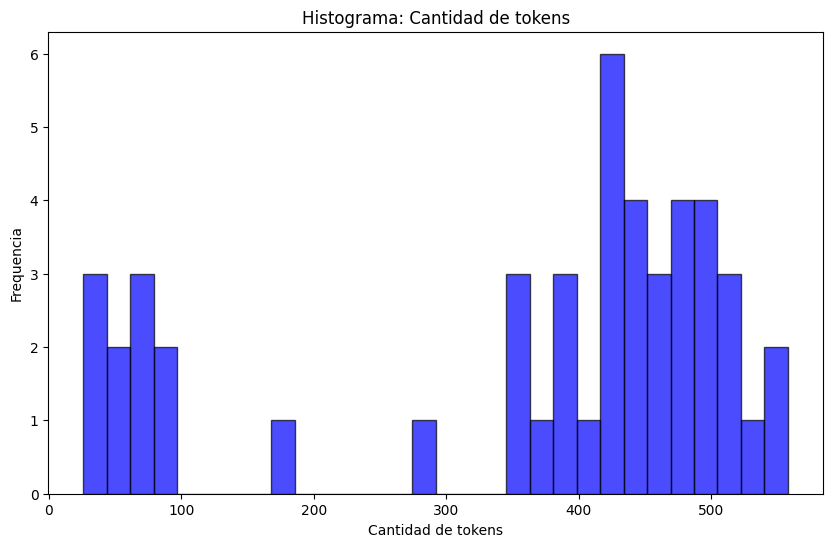

In [5]:
def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(t) for t in texts]

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histograma: Cantidad de tokens")
plt.xlabel("Cantidad de tokens")
plt.ylabel("Frequencia")
plt.show()

In [6]:
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content)
)

Num tokens in all context: 16943


# 1. ¿Incrustar de cero?
# 2. ¿Elegir un encrustamiento guardado?

In [7]:
user_input = input("Elige 1 o 2: ")

if user_input.lower() == "1":
    print('Elegiste 1')
    global_embeddings = [embeddings.embed_query(txt) for txt in texts]

    embed_name = input('¿Cómo se llama esta incrustación?: ') + '_emb' + '.txt'
    with open(rf'./embed/{embed_name}', 'w') as f:
        for i in global_embeddings:
            f.write("%s\n" % i)
    
elif user_input.lower() == "2":
    print('Elegiste 2')
    global_embeddings = []

    embed_name = input('Nombre del encrustamiento: ') + '_emb' + '.txt'

    with open(rf'./embed/{embed_name}', 'r') as f:
        for i in f:
            x = ast.literal_eval(i.strip())  # Convertir la cadena a lista de números
            global_embeddings.append(x)

    global_embeddings = np.array(global_embeddings, dtype=float)
    
elif user_input != "1" and user_input != "2":
    print("No seleccionaste ningún encrustamiento.")

Elegiste 1


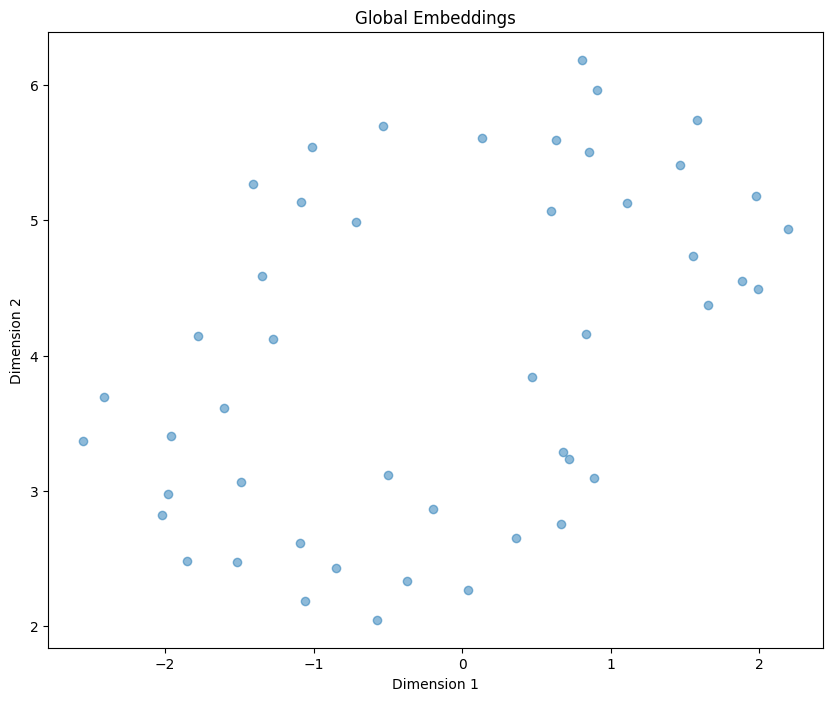

In [9]:
def reduce_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

dim = 2
global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


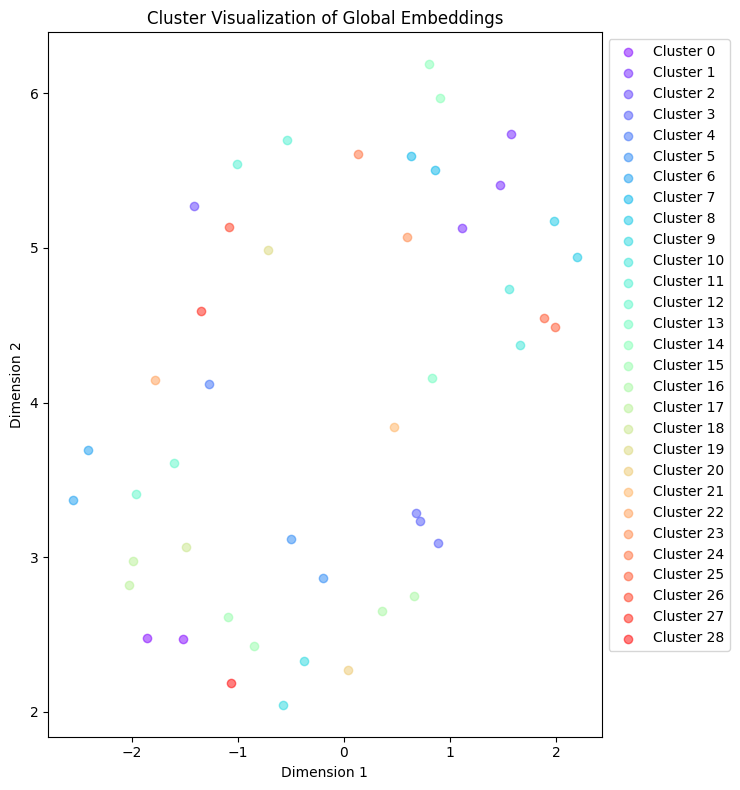

In [10]:
def get_optimal_clusters(embeddings: np.ndarray, max_clusters: int = 50, random_state: int = 1234):
    max_clusters = min(max_clusters, len(embeddings))
    bics = [GaussianMixture(n_components=n, random_state=random_state).fit(embeddings).bic(embeddings)
            for n in range(1, max_clusters)]
    return np.argmin(bics) + 1

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state).fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.75, 1])

In [11]:
simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Texto': texts,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})
# print(df.head(3))
df.head()

,Texto,Embedding,Cluster
0,"See discussions, st ats, and author pr ofiles ...","[0.63340175, 5.5944686]",7
1,73 Estrategias para fortalecer las capacidades...,"[0.8569969, 5.504269]",7
2,INNOV ACIÓN ORGANIZACIONAL: Experiencias y ref...,"[0.8895133, 3.0940366]",3
3,75 Estrategias para fortalecer las capacidades...,"[1.1109264, 5.1271853]",1
4,ellas que cogeneran energía eléctrica a partir...,"[1.9923034, 4.4907656]",25


In [12]:
def format_cluster_texts(df):
    clustered_texts = {}
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Texto'].tolist()
        clustered_texts[cluster] = " --- ".join(cluster_texts)
    return clustered_texts

clustered_texts = format_cluster_texts(df)
clustered_texts

{7: 'See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/364350695 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca Chapt er · Dec ember 2021 CITATIONS 0READS 26 2 author s, including: Isabel Cristina Quint ero Univ ersidad P ontificia Boliv ariana 32 PUBLICA TIONS \xa0\xa0\xa031 CITATIONS \xa0\xa0\xa0 SEE PROFILE All c ontent f ollo wing this p age was uplo aded b y Isabel Cristina Quint ero on 18 Oct ober 2022. The user has r equest ed enhanc ement of the do wnlo aded file. --- 73 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca ESTRATEGIAS PARA FORTALECER LAS  CAPACIDADES DE INNOV ACIÓN EN EMPRESAS DEL  CLÚSTER DE LA CAÑA EN EL V ALLE DEL CAUCA Edwin Fernando Montoya3 Isabel Cristina Quintero Sepúlveda4 Resumen La innovación está asociada a las dinámicas económicas y sociales, por lo que 

# Aplicar análisis a base de datos para determinar de qué habla (tema principal) cada clúster.

In [13]:
template = """Eres un revisor bibliográfico profesional encargado de crear resúmenes extremadamente detallados del texto proporcionado.

Texto:
{text}
"""

prompt = PromptTemplate.from_template(template)
chain = prompt | detailed_turbo_llm | StrOutputParser()

In [14]:
summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary

summaries

{7: 'El texto proporcionado discute estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca. Se destaca que la innovación va más allá de la invención, ya que se enfoca en el desarrollo productivo y la transformación del conocimiento científico y tecnológico para generar riqueza económica, bienestar social y desarrollo humano. Se menciona que la organización empresarial juega un papel crucial en la generación de la innovación en diferentes sectores económicos, especialmente aquellos con mayor potencial para el país.\n\nLa investigación presenta tres casos empresariales en el clúster de la caña de azúcar en el departamento del Valle del Cauca, Colombia, donde se analizan las capacidades de innovación y se proponen acciones estratégicas que las empresas podrían implementar para mejorar sus capacidades y resultados en innovación. Se destaca la importancia de desarrollar un marco de acciones estratégicas para fomentar la innovación 

In [15]:
embedded_summaries = [embeddings.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [16]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

clustered_summaries

{0: ['El texto proporcionado discute estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca. Se destaca que la innovación va más allá de la invención, ya que se enfoca en el desarrollo productivo y la transformación del conocimiento científico y tecnológico para generar riqueza económica, bienestar social y desarrollo humano. Se menciona que la organización empresarial juega un papel crucial en la generación de la innovación en diferentes sectores económicos, especialmente aquellos con mayor potencial para el país.\n\nLa investigación presenta tres casos empresariales en el clúster de la caña de azúcar en el departamento del Valle del Cauca, Colombia, donde se analizan las capacidades de innovación y se proponen acciones estratégicas que las empresas podrían implementar para mejorar sus capacidades y resultados en innovación. Se destaca la importancia de desarrollar un marco de acciones estratégicas para fomentar la innovación

In [17]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

final_summaries

{0: 'En el texto proporcionado se discuten estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca. Se destaca que la innovación va más allá de la invención, ya que se enfoca en el desarrollo productivo y la transformación del conocimiento científico y tecnológico para generar riqueza económica, bienestar social y desarrollo humano. Se menciona que la organización empresarial juega un papel crucial en la generación de la innovación en diferentes sectores económicos, especialmente aquellos con mayor potencial para el país.\n\nLa investigación presenta tres casos empresariales en el clúster de la caña de azúcar en el departamento del Valle del Cauca, Colombia, donde se analizan las capacidades de innovación y se proponen acciones estratégicas que las empresas podrían implementar para mejorar sus capacidades y resultados en innovación. Se destaca la importancia de desarrollar un marco de acciones estratégicas para fomentar la inno

In [18]:
texts_from_df = df['Texto'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

In [19]:
combined_texts[:10]

['See discussions, st ats, and author pr ofiles f or this public ation at : https://www .researchgate.ne t/public ation/364350695 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca Chapt er · Dec ember 2021 CITATIONS 0READS 26 2 author s, including: Isabel Cristina Quint ero Univ ersidad P ontificia Boliv ariana 32 PUBLICA TIONS \xa0\xa0\xa031 CITATIONS \xa0\xa0\xa0 SEE PROFILE All c ontent f ollo wing this p age was uplo aded b y Isabel Cristina Quint ero on 18 Oct ober 2022. The user has r equest ed enhanc ement of the do wnlo aded file.',
 '73 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca ESTRATEGIAS PARA FORTALECER LAS  CAPACIDADES DE INNOV ACIÓN EN EMPRESAS DEL  CLÚSTER DE LA CAÑA EN EL V ALLE DEL CAUCA Edwin Fernando Montoya3 Isabel Cristina Quintero Sepúlveda4 Resumen La innovación está asociada a las dinámicas económicas y sociales, por lo que tra

In [20]:
# Nombre del archivo de texto
file_name = input('Nombre del archivo: ') + '.txt'

# Escribir la lista en el archivo de texto
with open(file_name, 'w', encoding='utf-8') as f:
    for t in combined_texts:
        f.write("%s\n" % t)

# Leer el contenido del archivo y mostrarlo
with open(file_name, 'r', encoding='utf-8') as f:
    content = f.read()

textos = text_splitter.split_text(content)

# Guardar los kb en una carpeta (kbs)

### 1. Enseñar

In [21]:
persist_directory = input('¿Cómo se llama este knoledge-base?: ') + '_kb'
vectorstore = Chroma.from_texts(texts=textos,
                                embedding=embeddings,
                                persist_directory=persist_directory)
vectorstore.persist()
vectorstore = None
os.system(f'zip -r db.zip ./{persist_directory}')

c:\Users\luisr\OneDrive\Documentos\GitHub\1day_1thing\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  warn_deprecated(


1

### 2. Recordar (si y solo si Enseñar=Done) y pregunta de control

In [22]:
persist_directory = input('¿Qué knoledge-base deseas usar?: ') + '_kb'
embedding = OpenAIEmbeddings()
vectorstore = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)

def adjust_final_number(string: str, max_threshold: int, initial_number: int) -> int:
    final_number = initial_number
    while final_number < max_threshold:
        retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})
        docs = retriever.invoke(string)
        text = "".join([doc.page_content for doc in docs])
        if num_tokens_from_string(text) < max_threshold:
            final_number += 1
        else:
            break
    return final_number

final_number = adjust_final_number("¿Cuál es el tema pricipal del documento?", 10000, 4)
print(final_number)
retriever = vectorstore.as_retriever(search_kwargs={"k": final_number})

29


In [23]:
# Se personaliza el LLM
template = """
Eres Prometeo, un asistente personal de revisión biliográfica que habla Español.

Tu tarea consiste en:

1. Leer detalladamente la información proporcionada en documentos que generalmente son
artículos científicos en formato PDF.

2. Proporcionar respuestas extremadamente detalladas a cualquier tipo de pregunta relacionada 
con el contexto, especialmente a preguntas específicas. Evita concluir tus respuestas con un 
párrafo que comience con 'En resumen,...'. Varía las conclusiones de tus respuestas para que 
sean más diversas y creativas.

3. Ser carismático y ofrecer información sobre ti y tus funciones.

SIEMPRE debes responder con base al contexto proporcionado aqui: {context}.
        
Si no sabes la respuesta, puedes decir: 'No sé'.

NUNCA hables específicamente del contexto.

NUNCA terminar las respuestas con un resumen o una conclusión predecible.

Teniendo en cuenta TODO lo anterior, responde la siguiente pregunta: {question}
"""

prometeo_prompt = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | prometeo_prompt
    | turbo_llm
    | StrOutputParser()
)

rag_chain_with_source = RunnableParallel(
    {"context": retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain
)

In [24]:
def wrap_text_preserve_newlines(text, width=70):
    lines = text.split('\n')
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]
    wrapped_text = '\n'.join(wrapped_lines)
    return wrapped_text

def process_llm_response(llm_response):
    print(wrap_text_preserve_newlines(llm_response['answer']))
    print('\nReferencias:')
    for contexto in llm_response["context"][:5]:
        print(contexto)

In [25]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Quién o quiénes fueron los autores del artículo?
Los autores del artículo fueron Edwin Fernando Montoya y Isabel
Cristina Quintero Sepúlveda.

Referencias:
page_content='En el texto proporcionado se discuten estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca. Se destaca que la innovación va más allá de la invención, ya que se enfoca en el desarrollo productivo y la transformación del conocimiento científico y tecnológico para generar riqueza económica, bienestar social y desarrollo humano. Se menciona que la organización empresarial juega un papel crucial en la generación de la innovación en diferentes sectores económicos, especialmente aquellos con mayor potencial para el país.'
page_content='INNOV ACIÓN ORGANIZACIONAL: Experiencias y reflexiones del Valle del Cauca y Quindío.108 Nelson, R., y Winter, S. (1977). In search of a useful theory of innovation. Re- search Policy. 36-76. Nelson, R., y Winter, S. (1982). An evol

In [26]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿A qué institución pertenecen los autores del artículo?
Los autores del artículo pertenecen a la Universidad Pontificia
Bolivariana.

Referencias:
page_content='INNOV ACIÓN ORGANIZACIONAL: Experiencias y reflexiones del Valle del Cauca y Quindío.86 de datos de la Cámara de Comercio de Palmira (2019). Se identificaron los cargos  que podrían tener la información requerida para los objetivos de la investigación, se envió invitación vía e-mail, y se logró la participación final de 3 empresas cuyas características generales se describen en la Tabla 4. Tabla 4. Características generales de las empresas Empresa A Empresa B Empresa C Ciudad Florida Pradera Candelaria Codigo CIIU 161 1542 c1071 Startup No No Sí Procedencia Capital Nacional Mixto Nacional Cantidad Empleados 51-200 Mayor a 200 Mayor a 200 Sector Económico Servicios Agroindustria Agroindustria Ventas (miles millones) 1.000 a 7.000  59.000 a 65.000 7.000 a 59.000 Nota. Elaboración propia De acuerdo con la Tabla 4, las tres empresa

In [27]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿En qué año fue escrito el artículo?
El artículo fue escrito en el año 2021.

Referencias:
page_content='En el texto proporcionado se discuten estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca. Se destaca que la innovación va más allá de la invención, ya que se enfoca en el desarrollo productivo y la transformación del conocimiento científico y tecnológico para generar riqueza económica, bienestar social y desarrollo humano. Se menciona que la organización empresarial juega un papel crucial en la generación de la innovación en diferentes sectores económicos, especialmente aquellos con mayor potencial para el país.'
page_content='INNOV ACIÓN ORGANIZACIONAL: Experiencias y reflexiones del Valle del Cauca y Quindío.108 Nelson, R., y Winter, S. (1977). In search of a useful theory of innovation. Re- search Policy. 36-76. Nelson, R., y Winter, S. (1982). An evolutionary theory of economy change OCDE. (2013). Innovación en las 

In [29]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Puedes mencionar los referentes teóricos?
Sí, los referentes teóricos mencionados en el contexto incluyen las
ideas de Nelson & Winter (1982) sobre el cambio técnico y la
importancia de las rutinas organizacionales en la innovación. También
se hace referencia a Guan & Ma (2003) y su enfoque en las capacidades
de innovación tecnológica, así como a Yam et al. (2004) y su modelo de
gestión de la I+D. Además, se citan fuentes como el Manual de Oslo
(2018) para definir los tipos de innovación y la OCDE (2018) para
contextualizar la importancia de la innovación en el mercado
globalizado.

Referencias:
page_content='77 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca sus capacidades de innovación, para luego proponer un marco de acciones estraté- gicas para el fortalecimiento de las capacidades de innovación. La metodología es cuantitativa descriptiva, con corte transversal. El instrumento para identificar las capacidades de i

In [30]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuáles son los objetivos del estudio?
Los objetivos del estudio son identificar y medir las capacidades de
innovación en las empresas del sector del clúster de la caña en el
Valle del Cauca y su zona de influencia, así como proponer acciones
estratégicas para fortalecer estas capacidades de innovación
empresarial. Además, se busca caracterizar el sector de la
agroindustria en Palmira, identificar las empresas del clúster de la
caña de azúcar en la región, medir las capacidades de innovación y
generar recomendaciones estratégicas para mejorar dichas capacidades.

Referencias:
page_content='de las capacidades de innovación en las empresas del clúster de la caña de azúcar en el Valle del Cauca. Para lograr el objetivo se hizo un estudio de casos múltiple en tres  empresas del  clúster de la caña de azúcar, donde se caracterizaron las empresas y se identificaron --- transversal. A través de un estudio de caso múltiple en tres em-presas del clúster de la caña de azúcar en el Valle del Cauc

In [31]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuál es la metodología empleada en el estudio?
La metodología empleada en el estudio es cuantitativa descriptiva, con
corte transversal. Se utilizó un cuestionario basado en el modelo de
Yam (2004) para identificar las capacidades de innovación de las
empresas en el clúster de la caña de azúcar en el Valle del Cauca.
Esta metodología permitió caracterizar las empresas, identificar sus
actividades de innovación, evaluar sus capacidades y desempeño
financiero, y finalmente proponer estrategias para fortalecer sus
capacidades de innovación.

Referencias:
page_content='77 Estrategias para fortalecer las capacidades de innovación en empresas del clúster de la caña en el Valle del Cauca sus capacidades de innovación, para luego proponer un marco de acciones estraté- gicas para el fortalecimiento de las capacidades de innovación. La metodología es cuantitativa descriptiva, con corte transversal. El instrumento para identificar las capacidades de innovación de las empresas se realizó a través

In [32]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cuáles fueron todos los resultados del estudio?
Los resultados del estudio mostraron que la empresa A tiene un nivel
bajo de desarrollo en la mayoría de las capacidades de innovación
analizadas, especialmente en las capacidades estratégicas y de
aprendizaje. La empresa B, por otro lado, presenta un nivel medio en
la mayoría de las capacidades, con un mayor enfoque en la capacidad de
comercialización. En cuanto a la empresa C, se destaca por tener un
nivel alto de desarrollo en casi todas las capacidades de innovación,
especialmente en la capacidad de producción y gestión de recursos.
Además, se identificó que las empresas que generan mayores
innovaciones y diversificación de productos presentan un mejor
resultado en los niveles de desempeño financiero, especialmente en los
volúmenes de ventas y utilidades. Asimismo, se observó que las
exportaciones de las empresas varían, siendo la empresa B la que más
porcentaje de ventas de exportación tiene. En resumen, los resultados
muestran la d

In [28]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cómo los autores identifican la capacidad de innovación en las empresas?
Los autores identifican la capacidad de innovación en las empresas a
través de un cuestionario con escala Likert de 1 a 7, donde se evalúan
diferentes aspectos relacionados con la innovación, como el grado en
que los niveles directivos están integrados y controlan las
principales funciones de la empresa, la existencia de mecanismos de
seguimiento del progreso de los proyectos de innovación, la
comunicación con proveedores y clientes, la coordinación entre
actividades de I+D, marketing y fabricación, entre otros. Estas
evaluaciones permiten categorizar las capacidades de innovación en
niveles alto, medio o bajo, lo que proporciona una visión detallada de
la situación de cada empresa en cuanto a su capacidad para generar
innovaciones y adaptarse a los cambios del entorno.

Referencias:
page_content='productos incluidos los nuevos diseños, nuevas funciones y nuevos empaques para los productos. Aunque ninguna cuenta 

In [33]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cómo innovan las empresas estudiadas?
Las empresas estudiadas innovan principalmente a través del desarrollo
de nuevos productos y servicios, así como de la mejora de los
existentes. Se enfocan en la diversificación del portafolio de
productos, la creación de nuevos procesos para aumentar la
productividad y la implementación de nuevos diseños, funciones y
empaques. Además, se destaca que las empresas B y C han centrado sus
actividades de innovación en el desarrollo de nuevos productos que han
tenido impacto tanto a nivel nacional como internacional, lo que
refleja su enfoque en la expansión de mercado y la competitividad. Por
otro lado, la empresa A, que presta servicios de apoyo a la
agricultura, ha tenido un enfoque más operativo y centrado en el
campo, lo que ha limitado su capacidad de generar innovaciones en
productos o servicios. En resumen, las empresas estudiadas buscan
mejorar su posición en el mercado a través de la innovación en sus
productos, procesos y servicios.

Referen

In [35]:
# Demo
query = input("Hazme una pregunta: ")
print(query)
llm_response = rag_chain_with_source.invoke(query)
process_llm_response(llm_response)

¿Cómo puede aportar el documento a la elaboración de un artículo científico que genere conocimiento capaz de promover la competitividad en las empresas?
El documento proporciona una visión detallada sobre las estrategias
para fortalecer las capacidades de innovación en empresas del clúster
de la caña en el Valle del Cauca. A través del análisis de casos
empresariales y la identificación de acciones estratégicas, se pueden
extraer recomendaciones específicas para mejorar las capacidades de
innovación en las empresas de este sector. Estas recomendaciones
pueden servir como base para la elaboración de un artículo científico
que genere conocimiento aplicable a la promoción de la competitividad
en las empresas. Al estudiar las capacidades de innovación y su
impacto en el desempeño empresarial, se pueden identificar áreas de
mejora y oportunidades de crecimiento que contribuyan a fortalecer la
posición competitiva de las empresas en el mercado. Además, el
documento destaca la importancia de 

# Hacer historial y guardar conversaciones para medir efectividad.

In [ ]:
# Para archivos grandes debes dividir el texto

# # Diccionario inicial
# data = {
#     2: 'El impacto de la innovación de producto, innovación de proceso, innovación organizacional y la percepción de la corrupción en la rentabilidad empresarial en Colombia es un tema abordado en un estudio realizado por Gueiriluz Romero Chaparro y Juan Felipe Gómez Quiceno de la Universidad EAN. El propósito de la investigación es analizar'
# }

# # Obtener el texto original
# original_text = data[2]

# # Encontrar el punto medio
# mid_point = len(original_text) // 2

# # Definir el tamaño del solapamiento
# overlap_size = 50

# # Calcular los puntos de división con solapamiento
# start_overlap = max(mid_point - overlap_size // 2, 0)
# end_overlap = min(mid_point + overlap_size // 2, len(original_text))

# # Dividir el texto en dos partes con solapamiento
# first_half = original_text[:end_overlap]
# second_half = original_text[start_overlap:]

# # Crear nuevas llaves en el diccionario
# data[2] = first_half
# data[3] = second_half

# # Imprimir el diccionario actualizado
# print(data)